In [1]:
import scipy.signal
import torch
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import scipy
import numpy as np
from src.utils.misc import MovingAvg
from src.utils.fourier import sphere2complex, complex2sphere

# def moving_average_freq_response(N, sample_rate, freq):
#     omega = 2 * torch.pi * freq / sample_rate
#     # SMA coefficients
#     b = np.ones(N)
#     a = np.array([N] + [0]*(N-1))

#     # Calculate the frequency response
#     w, h = scipy.signal.freqz(b, a, worN=omega)
#     # w *= sample_rate / (2 * np.pi)                      # Convert from rad/sample to Hz
#     return h

def moving_average_freq_response(N, sample_rate, freq):
    omega = 2 * torch.pi * freq / sample_rate
    coeff = torch.exp(-1j * omega * (N - 1) / 2) / N
    omega = torch.where(omega == 0, 1e-5, omega)
    Hw = coeff * torch.sin(omega * N / 2) / torch.sin(omega / 2)
    return Hw

# def moving_avg(x, N):
#     avg = torch.nn.AvgPool1d(kernel_size=N, stride=1)
#     front = x[:, 0:1, :].repeat(1, N // 2, 1)
#     end = x[:, -1:, :].repeat(1, N - 1 - N // 2, 1)
#     x = torch.cat([front, x, end], dim=1)
#     x = avg(x.permute(0, 2, 1))
#     x = x.permute(0, 2, 1)
#     return x



original signal

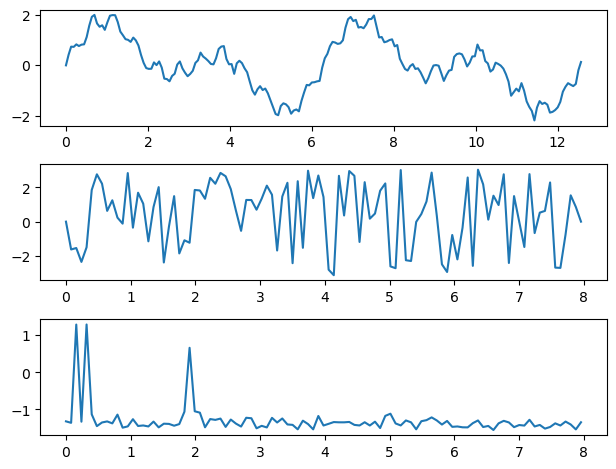

In [12]:
t = torch.linspace(0, 4*torch.pi, 200)
sample_rate = len(t)/(t.max()-t.min())
x = torch.sin(t) + torch.sin(2*t) + 0.3*torch.sin(12*t) + 0.1*torch.randn(t.shape)
x_freq = torch.fft.rfft(x, norm='ortho')
theta, phi = complex2sphere(x_freq.real, x_freq.imag)

freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()
phase[torch.abs(phase) < 1] = 0
fig, axs = plt.subplots(3)
axs[0].plot(t, x)
# axs[1].plot(freq, x_freq.real)
# axs[2].plot(freq, x_freq.imag)
axs[1].plot(freq, theta)
axs[2].plot(freq, phi)
fig.tight_layout()

manuplate on the frequency domain

tensor([ 2.2625,  2.3469,  2.3961,  2.4170,  2.4241,  2.4320,  2.4466,  2.4627,
         2.4663,  2.4434,  2.3871,  2.3026,  2.2045,  2.1096,  2.0283,  1.9596,
         1.8925,  1.8130,  1.7121,  1.5919,  1.4652,  1.3491,  1.2566,  1.1900,
         1.1402,  1.0927,  1.0352,  0.9656,  0.8929,  0.8326,  0.7985,  0.7950,
         0.8147,  0.8422,  0.8625,  0.8685,  0.8649,  0.8648,  0.8820,  0.9233,
         0.9836,  1.0481,  1.1003,  1.1294,  1.1366,  1.1328,  1.1327,  1.1460,
         1.1715,  1.1972,  1.2069,  1.1883,  1.1398,  1.0713,  0.9984,  0.9344,
         0.8829,  0.8361,  0.7796,  0.7005,  0.5952,  0.4717,  0.3462,  0.2346,
         0.1449,  0.0733,  0.0072, -0.0670, -0.1558, -0.2542, -0.3476, -0.4193,
        -0.4588, -0.4670, -0.4552, -0.4385, -0.4273, -0.4213, -0.4093, -0.3757,
        -0.3091, -0.2082, -0.0835,  0.0485,  0.1737,  0.2874,  0.3966,  0.5149,
         0.6546,  0.8191,  1.0000,  1.1809,  1.3454,  1.4851,  1.6034,  1.7126,
         1.8263,  1.9515,  2.0835,  2.20

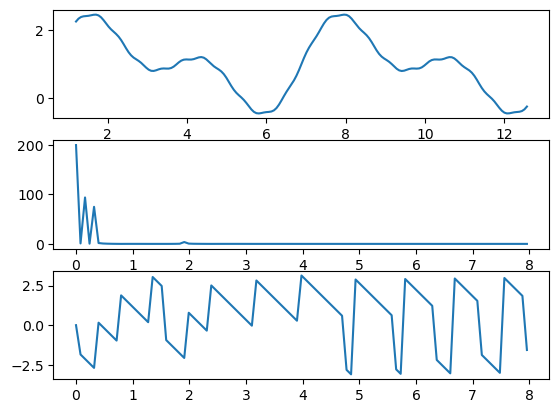

In [3]:
N = 20
h = moving_average_freq_response(N, sample_rate=sample_rate, freq=freq)
x_freq_new = x_freq * h
mag = x_freq_new.abs()
phase = x_freq_new.angle()
x_new = torch.fft.irfft(x_freq_new)
print(x_new[N-1:])
fig, axs = plt.subplots(3)
axs[0].plot(t[N-1:], x_new[N-1:])
axs[1].plot(freq, mag)
axs[2].plot(freq, phase)

manuplate on the time domain

tensor([ 2.2625,  2.3469,  2.3961,  2.4170,  2.4241,  2.4320,  2.4466,  2.4627,
         2.4663,  2.4434,  2.3871,  2.3026,  2.2045,  2.1096,  2.0283,  1.9596,
         1.8925,  1.8130,  1.7121,  1.5919,  1.4652,  1.3491,  1.2566,  1.1900,
         1.1402,  1.0927,  1.0352,  0.9656,  0.8929,  0.8326,  0.7985,  0.7950,
         0.8147,  0.8422,  0.8625,  0.8685,  0.8649,  0.8648,  0.8820,  0.9233,
         0.9836,  1.0481,  1.1003,  1.1294,  1.1366,  1.1328,  1.1327,  1.1460,
         1.1715,  1.1972,  1.2069,  1.1883,  1.1398,  1.0713,  0.9984,  0.9344,
         0.8829,  0.8361,  0.7796,  0.7005,  0.5952,  0.4717,  0.3462,  0.2346,
         0.1449,  0.0733,  0.0072, -0.0670, -0.1558, -0.2542, -0.3476, -0.4193,
        -0.4588, -0.4670, -0.4552, -0.4385, -0.4274, -0.4213, -0.4093, -0.3757,
        -0.3091, -0.2082, -0.0835,  0.0485,  0.1737,  0.2874,  0.3966,  0.5149,
         0.6546,  0.8191,  1.0000,  1.1809,  1.3454,  1.4851,  1.6034,  1.7126,
         1.8263,  1.9515,  2.0835,  2.20

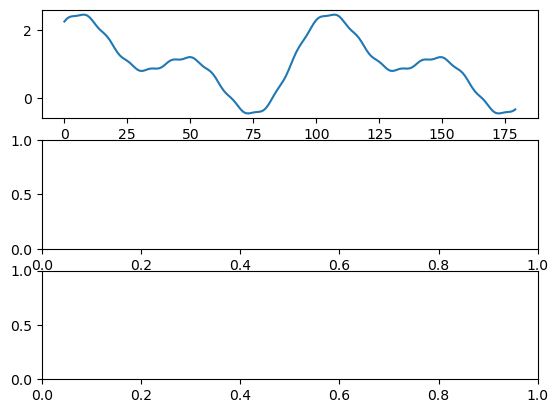

In [4]:
x_new = MovingAvg(x.reshape(1, -1, 1), N).flatten()
# x_new = np.convolve(np.concatenate([x[-N+1:],x]), np.ones(N)/N, mode='valid')
x_freq = torch.fft.rfft(x_new)
freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()

# mag = x_freq_new.abs()
# phase = x_freq_new.angle()
# # print(phase)
# x = torch.fft.irfft(x_freq_new)
print(x_new[N//2:-N//2])
fig, axs = plt.subplots(3)
axs[0].plot(x_new[N//2:-N//2])
# axs[1].plot(freq, mag)
# axs[2].plot(freq, phase)

In [9]:
import torch
from src.models.diffusion import MovingAvgDiffusion
from src.models.backbone import MLPBackbone
from src.utils.filters import get_factors, MovingAvgTime
seq_len = 200
bb = MLPBackbone(1,seq_len,10,1)
m = MovingAvgDiffusion(backbone=bb)
x = torch.rand((3, seq_len, 4)).float()
# x = torch.arange(30).reshape(5,seq_len,1).float()
print(x.shape)
print(torch.fft.rfft(x, dim=1).shape)
print(torch.fft.rfftfreq(seq_len).shape)

# t = torch.randint(0, len(get_factors(seq_len)), (x.shape[0],))
# print(get_factors(seq_len))
# print(t)
# m.forward(x, t)

# list(range(6, 0, -1))

torch.Size([3, 200, 4])
torch.Size([3, 101, 4])
torch.Size([101])
